In [2]:
import json
import re
import matplotlib.pyplot as plt
import numpy as np

In [15]:
result_files = {
    "22B": "/raid/s3/opengptx/behzad_shomali/checkpoints/2025-08-14__15-48-49_c15155eb/wmt20_results/results/Behzadshomali/Multilingual5/results_2025-08-15T16-34-30.023999.json",
    "18B": "/raid/s3/opengptx/behzad_shomali/wmt20_results/18-11B/results/Behzadshomali/Multilingual5/results_2025-08-18T00-31-07.152742.json"
}

In [16]:
def plot_each_model_result(result_file, ax, labels=None, sorted_benchmarks=None, legend=None):
    results_json = json.load(open(result_file, "r"))
    results = {}
    benchmarks_num = 0

    benchmarks = results_json["results"].keys()
    for benchmark in benchmarks:
        if  benchmark not in ["all"]:
            results[benchmark] = results_json["results"][benchmark]
            benchmarks_num += 1

    assert benchmarks_num == len(results), f"Expected {benchmarks_num} benchmarks, but got {len(results)}"

    if sorted_benchmarks is None:
        results = dict(sorted(results.items(), key=lambda item: item[1]["bleu"], reverse=False))
        sorted_benchmarks = list(results.keys())

    if labels is None:
        labels = []
        pattern = r"wmt20:(.+?)\|(\d+)"
        for key in sorted_benchmarks:
            match = re.search(pattern, key)
            if match:
                lang_pair = match.group(1)
                lang_pair = lang_pair.replace("_", "")
                labels.append(f"{lang_pair} (#{match.group(2)})")
            else:
                print(key)

    current_results, current_labels, current_errors = [], [], []
    current_results_indices = []
    for index, benchmark in enumerate(sorted_benchmarks):
        if benchmark in results:
            current_results.append(results[benchmark]["bleu"])
            current_labels.append(labels[sorted_benchmarks.index(benchmark)])
            current_errors.append(results[benchmark]["bleu_stderr"])
            current_results_indices.append(index)
        else:
            print(f"Warning: {benchmark} not found in results")
    if legend is not None:
        ax.barh(current_labels, current_results, label=legend, alpha=0.5)
    else:
        ax.barh(current_labels, current_results, alpha=0.5)

    # plot the std deviation as error bars
    ax.errorbar(
        current_results,
        current_results_indices,
        xerr=current_errors,
        fmt='o',
        # label=f"{legend} (stderr)"
    )

    ax.set_xlabel('BLEU Score')
    ax.set_title('WMT20 Evaluation Results')
    ax.legend()

    return ax, sorted_benchmarks, labels

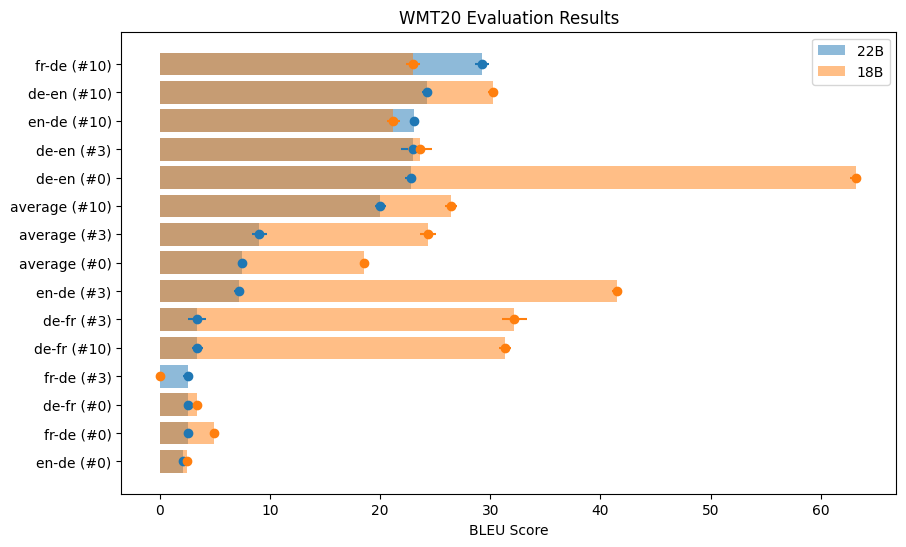

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

sorted_benchmarks = None
labels = None
for legend, result_file in result_files.items():
    ax, sorted_benchmarks, labels = plot_each_model_result(result_file, ax, sorted_benchmarks=sorted_benchmarks, labels=labels, legend=legend)
